In [1]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


In [2]:

class ConvAutoencoder(nn.Module):
    def __init__(self, latent_dim=32):
        super(ConvAutoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),  # [1, 28, 28] → [16, 14, 14]
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), # [16, 14, 14] → [32, 7, 7]
            nn.ReLU(),
            nn.Flatten(),                              # [32, 7, 7] → [1568]
            nn.Linear(32 * 7 * 7, latent_dim)           # [1568] → [latent_dim]
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 32 * 7 * 7),          # [latent_dim] → [1568]
            nn.ReLU(),
            nn.Unflatten(1, (32, 7, 7)),                # [1568] → [32, 7, 7]
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),  # [32, 7, 7] → [16, 14, 14]
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),   # [16, 14, 14] → [1, 28, 28]
            nn.Sigmoid()
        )

    def forward(self, x):
        latent = self.encoder(x)
        out = self.decoder(latent)
        return out

    def encode(self, x):
        return self.encoder(x)

    def decode(self, z):
        return self.decoder(z)


In [3]:

transform = transforms.ToTensor()
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)


100.0%
100.0%
100.0%
100.0%


In [4]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ConvAutoencoder(latent_dim=32).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for imgs, _ in train_loader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        loss = criterion(outputs, imgs)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}")


Epoch [1/5], Loss: 0.0480
Epoch [2/5], Loss: 0.0116
Epoch [3/5], Loss: 0.0089
Epoch [4/5], Loss: 0.0079
Epoch [5/5], Loss: 0.0072


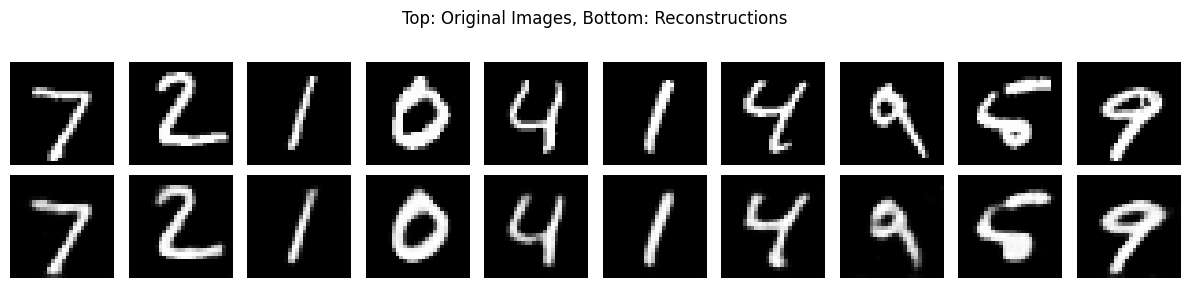

In [5]:

model.eval()
with torch.no_grad():
    imgs, _ = next(iter(test_loader))
    imgs = imgs.to(device)
    outputs = model(imgs)
    
    # Plot original and reconstructed images
    imgs = imgs.cpu().numpy()
    outputs = outputs.cpu().numpy()
    
    fig, axes = plt.subplots(2, 10, figsize=(12, 3))
    for i in range(10):
        axes[0, i].imshow(imgs[i][0], cmap='gray')
        axes[0, i].axis('off')
        axes[1, i].imshow(outputs[i][0], cmap='gray')
        axes[1, i].axis('off')
    plt.suptitle("Top: Original Images, Bottom: Reconstructions")
    plt.tight_layout()
    plt.show()


## Define 7-Segment Encoding and MLP Classifier

In [6]:

# 7-segment binary encodings for digits 0 to 9
import numpy as np

digit_to_segment = {
    0: [1, 1, 1, 0, 1, 1, 1],
    1: [0, 0, 1, 0, 0, 1, 0],
    2: [1, 0, 1, 1, 1, 0, 1],
    3: [1, 0, 1, 1, 0, 1, 1],
    4: [0, 1, 1, 1, 0, 1, 0],
    5: [1, 1, 0, 1, 0, 1, 1],
    6: [1, 1, 0, 1, 1, 1, 1],
    7: [1, 0, 1, 0, 0, 1, 0],
    8: [1, 1, 1, 1, 1, 1, 1],
    9: [1, 1, 1, 1, 0, 1, 1],
}
segment_labels = torch.tensor([digit_to_segment[i] for i in range(10)], dtype=torch.float32)


In [7]:

class SegmentMLP(nn.Module):
    def __init__(self, input_dim=32, hidden_dim=64):
        super(SegmentMLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 7),
            nn.Sigmoid()  # Outputs between 0 and 1 for each segment
        )

    def forward(self, x):
        return self.model(x)


## Train MLP and Generate Confusion Matrix

In [8]:

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Prepare training data: get latent vectors and segment labels
def prepare_latent_features(model, data_loader):
    model.eval()
    features = []
    labels = []
    with torch.no_grad():
        for imgs, digits in data_loader:
            imgs = imgs.to(device)
            latent = model.encode(imgs)
            for i in range(len(digits)):
                features.append(latent[i].cpu().numpy())
                labels.append(digit_to_segment[digits[i].item()])
    return torch.tensor(features, dtype=torch.float32), torch.tensor(labels, dtype=torch.float32)

train_features, train_labels = prepare_latent_features(model, train_loader)
test_features, test_labels_raw = prepare_latent_features(model, test_loader)

# Train the MLP
mlp = SegmentMLP(input_dim=32).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-3)

num_epochs = 10
for epoch in range(num_epochs):
    mlp.train()
    inputs = train_features.to(device)
    targets = train_labels.to(device)
    outputs = mlp(inputs)
    loss = criterion(outputs, targets)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")


C:\Users\dell\AppData\Local\Temp\ipykernel_79844\3065111822.py:16: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:257.)
  return torch.tensor(features, dtype=torch.float32), torch.tensor(labels, dtype=torch.float32)


Epoch [1/10], Loss: 1.4801
Epoch [2/10], Loss: 1.3488
Epoch [3/10], Loss: 1.2268
Epoch [4/10], Loss: 1.1149
Epoch [5/10], Loss: 1.0137
Epoch [6/10], Loss: 0.9237
Epoch [7/10], Loss: 0.8453
Epoch [8/10], Loss: 0.7783
Epoch [9/10], Loss: 0.7226
Epoch [10/10], Loss: 0.6775


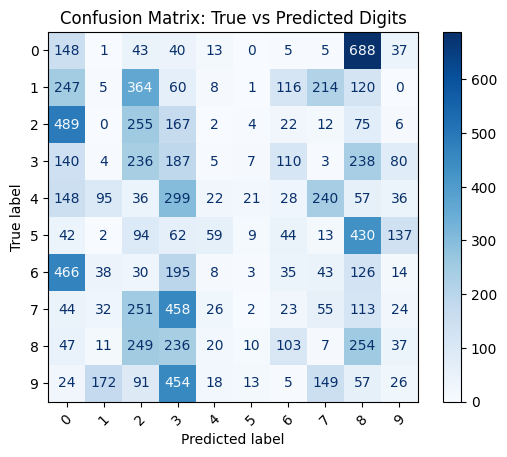

In [9]:

# Predict and generate confusion matrix
mlp.eval()
with torch.no_grad():
    preds = mlp(test_features.to(device)).cpu().numpy()

# Match prediction to closest digit using Hamming distance
def predict_digit(pred):
    min_dist = float('inf')
    best_digit = -1
    for digit, seg in digit_to_segment.items():
        dist = np.sum(np.round(pred) != seg)
        if dist < min_dist:
            min_dist = dist
            best_digit = digit
    return best_digit

y_pred = [predict_digit(p) for p in preds]
y_true = []

# Rebuild true digit labels from test_loader (since we only used segment labels before)
for _, digits in test_loader:
    y_true.extend(digits.numpy())

# Truncate to match prediction length if needed
y_true = y_true[:len(y_pred)]

# Generate and display confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(range(10)))
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix: True vs Predicted Digits")
plt.show()
